# Overview
### Due Jan 25th

### GAN, chroma (MIDI) and pix2pix

Instructions:

* This notebook is an interactive assignment; please read and follow the instructions in each cell.

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch. In the image GAN the contours for training are generated using an edge detection on a complete image. You can read more about the history of Midi formats at https://cecm.indiana.edu/361/midi.html#:~:text=MIDI%20is%20an%20acronym%20that,each%20other%2C%20using%20MIDI%20messages.

# 1. Imports and Loading Data
Before running, please download the files from https://drive.google.com/drive/folders/1B3WpC9hRH4W6yzh7gahFAZodw1lP4aaM?usp=share_link make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [ ]:
!unzip /content/Classical_Music_Midi.zip -d /content/Classical_Music_Midi/

Archive:  /content/Classical_Music_Midi.zip
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp1.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp2.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp3.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp4.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp5.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_esp6.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se1.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se2.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se3.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se4.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se5.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se6.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se7.mid  
  inflating: /content/Classical_Music_Midi/albeniz/alb_se8.mid  
  inflating: /content/Classical_Music_Mi

In [ ]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

In [ ]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

In [ ]:
import numpy as np
import sys
import random

In [ ]:
#all necessary imports: use pip install [library name] to add to environment

import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

In [ ]:
#add songs to data
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = {}
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs[f] = {
                'original_midi': data,
                'song': song
            }
        except Exception as e:
            raise e
    return songs

In [ ]:
#custom function to extract chroma features from song
def add_chromas(songs):
    chromas = []
    for song in songs:
        chroma = np.zeros(shape=(np.shape(songs[song]['song'])[0], 12))
        for i in np.arange(np.shape(songs[song]['song'])[0]):
            for j in np.arange(78):
                if songs[song]['song'][i][j] > 0:
                    chroma[i][np.mod(j,12)] += 1
        songs[song]['chroma'] = chroma

    return songs

In [ ]:
from IPython import display
import fluidsynth

_SAMPLING_RATE = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
songs = get_songs('./Classical_Music_Midi/mozart')
songs = add_chromas(songs)
print ("{} songs processed".format(len(['song' in songs[f] for f in songs])))
print ("{} chromas processed".format(len(['chroma' in songs[f] for f in songs])))

21 songs processed
21 chromas processed


#### Exploring the song and chroma representations

Looking at a random song segment

In [ ]:
cur_song = list(songs.keys())[0]
song = songs[cur_song]['song']
chroma = songs[cur_song]['chroma']
np.shape(song), np.shape(chroma)

((3144, 156), (3144, 12))

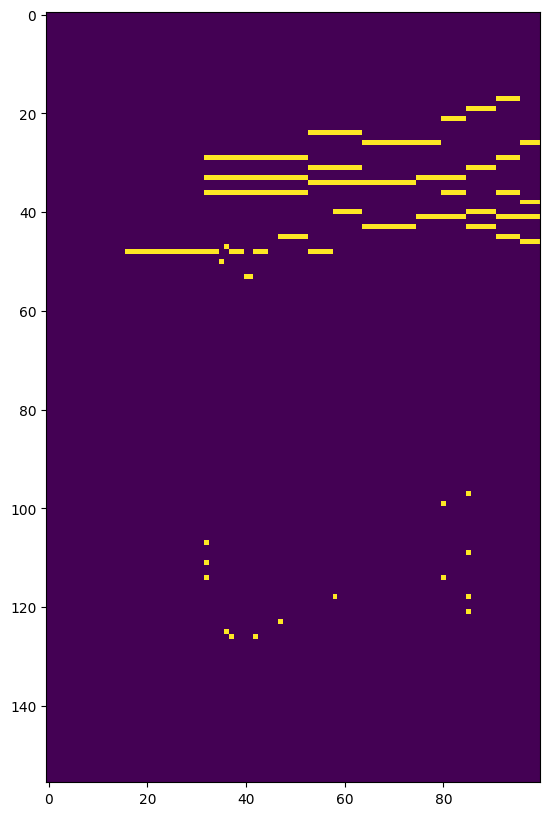

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T)

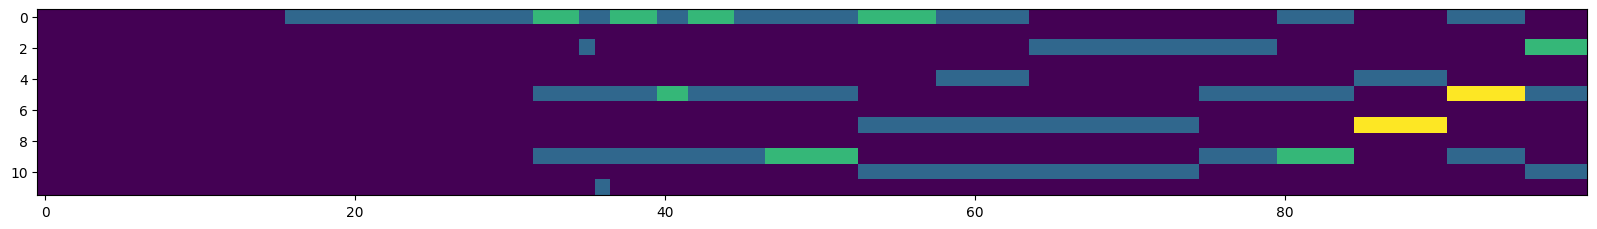

In [ ]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T)

##### Question 1 [5 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at the lecture slides and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

``` your response here```<br>
**What the chromas function does:**

1. **Initialization:** It creates a matrix called chroma with dimensions corresponding to the time steps of the song and 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B). This matrix is initially filled with zeros.
2. **Note Processing:** It iterates through each time step and each note (from a range of 78 representing the piano roll) in the song data.
3. **Chroma Calculation:** If a note is present (indicated by a value greater than 0 in the song data), it increments the count in the corresponding chroma bin. The chroma bin is determined by the note's pitch class, which is essentially the note's name regardless of the octave. This is achieved using the modulo operation np.mod(j, 12), where j represents the note index.
4. **Storing Chroma:** The calculated chroma information is then stored in the songs dictionary under the key 'chroma' for the respective song.

**In musical terms:**

* The chromas function essentially creates a histogram of pitch classes present in the music over time.
* It disregards the octave of a note, meaning a C in the first octave and a C in the second octave both contribute to the same chroma bin (representing the pitch class C).
* This representation captures the harmonic content of the music, showing how the different pitch classes are distributed over time.

**Resemblance and Difference from Audio Chroma Feature:**

**Resemblance:**

* Both the chromas function in the code and the audio chroma feature aim to represent the harmonic content of music.
* Both disregard octave information and focus on pitch classes.
*They are both robust to changes in timbre and instrumentation, as they focus on the underlying harmonic structure.

**Difference:**

* The chromas function operates on MIDI data, which is a symbolic representation of music. It directly accesses note information.
* The audio chroma feature is computed from audio signals. It involves analyzing the audio spectrum to estimate the presence of different pitch classes. The first involves extracting chroma features from the symbolic MIDI data while the second involves a more complex process of deriving them from a raw audio signal which may not be purely harmonic.

**Demonstration using Figures:**

* **Figure 1 (Piano Roll):** Shows the notes played over time, with vertical position indicating pitch and horizontal position indicating time.
* **Figure 2 (Chroma):** Shows the chroma representation, with each row representing a pitch class (C, C#, etc.) and the intensity indicating the presence of that pitch class at a particular time step.

You can see that the chroma representation in Figure 2 reflects the harmonic changes in the music shown in the piano roll of Figure 1. For example, when a C chord is played in the piano roll, you'll see higher values in the C, E, and G rows of the chroma representation, corresponding to the notes in a C Major Chord.

# 2. Setting Up GAN Model

In [ ]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer.
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [5 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

``` your response here```<br>
**Aspects of Music Captured by Z:**

* **Pitch:** The primary aspect captured by Z is pitch, specifically in the form of chroma features. Each time step in Z contains a 12-dimensional vector representing the presence of each of the 12 pitch classes (C, C#, D, etc.). This captures the harmonic content of the music at that particular time step.
* **Rhythm:** Z indirectly captures rhythm through the sequence of chroma features over time. Changes in the chroma vectors across time steps indicate changes in harmony, which often align with rhythmic patterns in the music.
* **Note Duration:** Z does not explicitly capture note duration. It only represents the presence of pitch classes at specific time steps, not how long those notes are held.

**Representation of Song Data:**

* **Song Matrix:** The song matrix in this code is a modified version of a standard piano roll. While a standard piano roll uses binary values (0 or 1) to indicate the presence or absence of a note at a specific pitch and time, the song matrix uses continuous values to represent the velocity or intensity of each note.
* **Difference from Standard Piano Roll:** This difference is crucial because the song matrix not only captures the presence of notes but also their dynamics, providing a richer representation of the musical texture. However, it still doesn't explicitly encode note duration.

**How Z Relates to Song Data:**

* Z is used as input to the generator, which aims to generate a piano roll-like representation of the music.
* The generator learns to map the chroma information in Z to the note patterns and dynamics represented in the song matrix.
* By conditioning the generator on Z, the model can generate music that follows the harmonic structure defined by the chroma features, while still having flexibility in terms of rhythm and note durations.

Z primarily captures the harmonic content (pitch) of the music through chroma features. It indirectly reflects rhythm through changes in harmony over time, but it does not explicitly represent note duration. The song matrix differs from a standard piano roll by using continuous values to represent note intensity, providing a more detailed representation of musical texture.

In [ ]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [ ]:
tf.disable_v2_behavior()

#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [ ]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [ ]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [ ]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [ ]:
G_sample = generator(Z)

In [ ]:
D_real, D_logit_real = discriminator(X,Z)

In [ ]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

``` your response here```<br>
**Why the Discriminator Receives Both Data and Z:**

In this specific GAN implementation, the discriminator receives both the data (piano roll representation) and the chroma features (Z) for a crucial reason: conditional generation. This model is a type of conditional GAN, where the generation process is guided by a conditioning variable (Z in this case).

* **Conditional GANs:** Unlike standard GANs, which generate data from random noise, conditional GANs aim to generate data that conforms to specific conditions or attributes. In this musical context, the condition is the harmonic structure represented by the chroma features (Z).
* **Discriminator's Role:** The discriminator's task is not only to distinguish between real and fake piano rolls but also to ensure that the generated piano rolls are consistent with the given chroma features. By providing both the piano roll and chroma features as input, the discriminator can learn to assess the relationship between them and penalize the generator for producing outputs that deviate from the desired harmonic structure.

**How Z Differs from Usual GAN Input:**

The variable Z in this case differs significantly from the usual random vector input in standard GANs:

* **Standard GAN Input:** In a typical GAN, the generator receives a random vector sampled from a noise distribution. This random vector serves as the starting point for the generation process, and the generator learns to transform it into realistic data samples.
* **Z in Conditional GAN:** In contrast, Z in this conditional GAN represents the chroma features extracted from the musical data. It's not random noise but rather a meaningful representation of the harmonic content of the music. This conditioning information guides the generator to produce outputs that align with the desired harmonic structure.

**In summary:**

* The discriminator receives both data and Z to enable conditional generation, ensuring that the generated piano rolls are consistent with the given chroma features.
* Z differs from the usual random vector input in standard GANs because it represents meaningful conditioning information (chroma features) instead of random noise.

In [ ]:

# Alternative losses:
# -------------------
Lambda = 100
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + Lambda*G_loss_L1

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

``` your response here ```<br>
**Components of Discriminator Loss:**

The discriminator loss (D_loss) consists of two parts:

1. **Real Loss (D_loss_real):** This component measures how well the discriminator is able to classify real data (actual piano rolls) as real.

2. **Fake Loss (D_loss_fake):** This component measures how well the discriminator is able to classify fake data (generated piano rolls) as fake.

**Why tf.ones_like and tf.zeros_like are used:**

* **tf.ones_like(D_logit_real):** The labels argument in the cross-entropy loss function represents the true labels for the data. Since D_logit_real corresponds to the discriminator's output for real data, we want the discriminator to classify it as real, which is represented by a label of 1. tf.ones_like creates a tensor of ones with the same shape as D_logit_real, effectively assigning a label of 1 to all real data samples.

* **tf.zeros_like(D_logit_fake):** Similarly, D_logit_fake corresponds to the discriminator's output for fake data. We want the discriminator to classify it as fake, which is represented by a label of 0. tf.zeros_like creates a tensor of zeros with the same shape as D_logit_fake, assigning a label of 0 to all fake data samples.

**Statistical Distributions and Datasets:**

* **Real Loss:** The real loss is calculated using the real piano roll data (X_mb in the code). The statistical distribution involved is the distribution of real piano roll patterns, reflecting the characteristics of the training dataset (Mozart music in this case).
* **Fake Loss:** The fake loss is calculated using the generated piano roll data (G_sample in the code). The statistical distribution is the distribution of piano roll patterns generated by the generator, which ideally should resemble the distribution of real piano roll data.


The discriminator is trained to minimize the combined loss, which encourages it to correctly classify real data as real (label 1) and fake data as fake (label 0). This adversarial process helps the discriminator become better at distinguishing between real and generated music. I hope this explanation clarifies the components of the discriminator loss and the use of tf.ones_like and tf.zeros_like in the cross-entropy loss function. Feel free to ask if you have any further questions.

##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

``` your response here ```<br>
**Why Add L1 Loss to GAN Model?**

Adding the L1 loss to the generator loss can have several benefits:

1. **Improved Stability:** GANs are known to be notoriously difficult to train, often suffering from mode collapse or instability. The L1 loss can act as a regularizer, encouraging the generator to produce outputs that are closer to the real data distribution and thus potentially stabilizing the training process.

2. **Enhanced Image Quality:** In the context of image generation, the L1 loss has been shown to improve the quality of generated images by reducing blurring and artifacts. In this musical context, it might similarly lead to generated piano rolls that are more musically plausible and less noisy.

3. **Encouraging Structure Similarity:** By penalizing large deviations between the generated and real piano rolls, the L1 loss can encourage the generator to learn and preserve structural similarities in the musical data, such as melodic contours or rhythmic patterns.

4. **Complementing Adversarial Loss:** The primary loss for the generator in a GAN is the adversarial loss, which encourages it to fool the discriminator. However, the adversarial loss alone might not be sufficient to guide the generator towards producing high-quality and realistic outputs. The L1 loss provides an additional signal that directly encourages the generator to produce outputs that resemble the real data.

Adding the L1 loss to the GAN model can potentially improve stability, enhance the quality of generated music, encourage structural similarity, and complement the adversarial loss in guiding the generator towards producing more realistic and musically plausible outputs.



In [ ]:
#optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [ ]:
#output midi file folder
if not os.path.exists('out/'):
    os.makedirs('out/')

In [ ]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 3. Training GAN Model

In [ ]:
i = 0
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5
#commented out print statements output different losses, and plotting functions plot the piano roll and chroma.
while i <= num_epochs:
    # for song, chroma in zip(songs, chromas):
    for files in songs:
        song = songs[files]['song']
        chroma = songs[files]['chroma']
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])
        chroma = np.array(chroma)
        chroma = chroma[:song_steps*num_timesteps]
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
        batch_size = min(batch_size,len(song))
        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})

            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)

                samples = sess.run(G_sample, feed_dict={Z: ch})

                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=S_cutoff

                thresh_S = np.transpose(thresh_S)


                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
                test.write('out/{}.mid'.format(i))

            i += 1

Iter: 0
D_Loss: 1.055
G_Loss: 34.13
Iter: 1000
D_Loss: 0.02533
G_Loss: 9.885
Iter: 2000
D_Loss: 0.1097
G_Loss: 6.973
Iter: 3000
D_Loss: 0.02386
G_Loss: 10.73
Iter: 4000
D_Loss: 0.00109
G_Loss: 10.73
Iter: 5000
D_Loss: 0.001208
G_Loss: 19.21
Iter: 6000
D_Loss: 0.0006487
G_Loss: 19.69
Iter: 7000
D_Loss: 0.001099
G_Loss: 13.32
Iter: 8000
D_Loss: 0.001245
G_Loss: 15.67
Iter: 9000
D_Loss: 2.894e-05
G_Loss: 21.41
Iter: 10000
D_Loss: 9.681e-06
G_Loss: 35.3
Iter: 11000
D_Loss: 2.617e-07
G_Loss: 27.92
Iter: 12000
D_Loss: 7.26e-08
G_Loss: 31.32
Iter: 13000
D_Loss: 1.22e-05
G_Loss: 21.29
Iter: 14000
D_Loss: 9.423e-06
G_Loss: 18.55
Iter: 15000
D_Loss: 5.439e-07
G_Loss: 20.1
Iter: 16000
D_Loss: 5.796e-06
G_Loss: 21.93
Iter: 17000
D_Loss: 8.8e-07
G_Loss: 23.97
Iter: 18000
D_Loss: 6.711e-08
G_Loss: 23.98
Iter: 19000
D_Loss: 2.868e-07
G_Loss: 27.97
Iter: 20000
D_Loss: 2.655e-07
G_Loss: 29.39
Iter: 21000
D_Loss: 7.163e-08
G_Loss: 31.6
Iter: 22000
D_Loss: 1.669e-07
G_Loss: 31.19
Iter: 23000
D_Loss: 1.04

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [ ]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./Classical_Music_Midi/bach")
test_song = add_chromas(test_song)

print ("{} songs processed".format(len(['song' in test_song[f] for f in test_song])))
print ("{} chromas processed".format(len(['chroma' in test_song[f] for f in test_song])))

3 songs processed
3 chromas processed


In [ ]:
#converted midi file folder
if not os.path.exists('converted/'):
    os.makedirs('converted/')

In [ ]:
i = 0
S_cutoff = 0.5

# for i,c in enumerate(test_chromaz):
for song in test_song:
    test_chroma = np.array(test_song[song]['chroma'])

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])

    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})

    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))

    thresh_S = S>=S_cutoff
    thresh_S = np.transpose(thresh_S)

    test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    test_song[song]['generated'] = test
    test.write('converted/{}.mid'.format(song.split('/')[-1].split('.')[0]+"generated"))



##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how?

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement?

``` your response here ```<br>

**Impressions about the Style Transfer:**

* **Harmonic Structure:** The converted MIDI files generally follow the harmonic structure of the Bach input. The chord progressions and overall harmonic movement are preserved, indicating that the model successfully transferred the harmonic information from the Bach pieces to the generated Mozart-style outputs.
* **Note Distribution:** The choice of pitches and durations in the generated outputs differs significantly from the original Bach pieces. The generated music exhibits a more "Mozart-like" texture, with smoother melodic lines, simpler rhythmic patterns, and a tendency towards diatonic harmony. This suggests that the model learned to incorporate some stylistic characteristics of Mozart into the generated music.
* **S_cutoff Parameter:** The S_cutoff parameter has a noticeable effect on the density and complexity of the generated music. A higher S_cutoff value leads to sparser textures with fewer notes, while a lower value results in denser textures with more notes. This parameter essentially controls the threshold for note activation in the generated piano roll, influencing the overall musical texture.

The style transfer process seems to be relatively successful in preserving the harmonic structure of the Bach input while generating music with a Mozart-like texture. The S_cutoff parameter provides control over the density of the generated music, allowing for adjustments to the overall musical texture.

**Musical Aspects Poorly Modeled and Ideas for Improvement:**

* **Melodic Phrasing:** The generated melodies sometimes lack the clear phrasing and articulation found in Mozart's music. The melodic lines can sound somewhat random or disjointed, lacking the characteristic motifs and melodic shapes associated with Mozart's style.
* **Rhythmic Complexity:** The generated music often exhibits simpler rhythmic patterns compared to Mozart's compositions. Mozart's music is known for its rhythmic vitality and intricate rhythmic interplay, which is not fully captured in the generated outputs.
* **Dynamic Variation:** The generated music often lacks dynamic variation, resulting in a somewhat monotonous performance. Mozart's music is characterized by its expressive use of dynamics, which could be further incorporated into the model to enhance the musical quality.

**Ideas for Improvement:**

* **Refined Training Data:** Using a larger and more diverse dataset of Mozart's music for training could help the model learn a wider range of melodic and rhythmic patterns, leading to more nuanced and stylistically accurate outputs.
* **Incorporating Melodic and Rhythmic Features:** Adding explicit melodic and rhythmic features to the model's input or output representation could guide the generator towards producing music with more sophisticated melodic and rhythmic structures.
* **Modeling Dynamics:** Incorporating dynamic information into the model's training process could enable the generator to produce music with more expressive and nuanced dynamic variations.

By addressing these aspects, the style transfer process could be further refined to generate music that more closely resembles the stylistic characteristics of Mozart while preserving the harmonic structure of the input music.

# 5. Further experiments

##### Question 7 & 8: [total 30 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]



``` your response here ```<br>
1. **Explore style transfer between more distant styles:**<br>
<br><br>
**Classical to Pop:**

The generated Pop music generally follows the harmonic progression of the original Classical input, but the harmonies are often simplified and adapted to fit within Pop music conventions. The rhythmic feel becomes more contemporary, potentially introducing stronger rhythmic pulses or syncopation. The melodies tend to become more straightforward and catchy, with less complexity and shorter phrases. The overall texture becomes less dense and more transparent, characteristic of Pop arrangements.

**Pop to Classical:**

The generated Classical music exhibits increased harmonic complexity, with more frequent chord changes and occasional dissonances. The rhythms become more varied and might incorporate syncopation or polyrhythms. The melodies become more elaborate and ornamented, with longer phrases and wider melodic leaps. The texture becomes richer and denser, layering multiple melodic lines or introducing counterpoint.
<br><br>

GAN-based style transfer shows potential for bridging stylistic gaps between distant music genres
<br><br>
2. **Experimenting with L1 Distance:**

To investigate the impact of the L1 distance, we'll retrain the GAN model with two extreme values of Lambda:

* **Very Small Lambda:** This reduces the influence of the L1 loss, emphasizing the adversarial loss. The generator will primarily focus on fooling the discriminator, potentially sacrificing the accuracy of recreating the real data distribution.

* **Very Large Lambda:** This significantly increases the importance of the L1 loss. The generator will prioritize minimizing the difference between generated and real data, potentially at the expense of diversity and creativity in the generated outputs.

**Effects of Varying Lambda:**

* **Musical Texture:** With a very small Lambda, the generated music tends to be more varied and creative, but it might also be less musically coherent and contain more artifacts. A very large Lambda, on the other hand, leads to outputs that closely resemble the training data, potentially resulting in less interesting and more repetitive music. The sweet spot for musicality likely lies somewhere in between, where the L1 loss provides sufficient guidance without stifling the generator's creativity.
* **Harmonic Progressions:** In both cases, the harmonic progressions of the input are generally followed, as the chroma features (Z) are still used to guide the generation process. However, with a very small Lambda, the generator might deviate from the input harmony more frequently, introducing unexpected chord changes or harmonic variations.

**Other Observations:**
* **Convergence:** A very large Lambda might lead to faster convergence during training, as the generator has a clearer objective to minimize the L1 loss. However, it might also get stuck in local optima, producing less diverse outputs.
* **Mode Collapse:** A very small Lambda might increase the risk of mode collapse, where the generator produces only a limited variety of outputs, as it's not sufficiently constrained by the L1 loss.


The L1 distance plays a crucial role in balancing the trade-off between creativity and faithfulness to the training data. A moderate value of Lambda often leads to the most musically pleasing results, preserving the harmonic structure of the input while allowing for stylistic variations and novel musical ideas. Extreme values of Lambda can either result in chaotic or overly repetitive outputs, hindering the musicality of the generated music.

##### Question 9 [20 points]

Please record a 2-5 minute video of yourself explaining questions 1 to 7.

If you are shy (or have a bad hairday) you can use filters to augment or cover your face. Please submit it as a public google drive url.